In [80]:
# basic imports 

import os # OS e.g directory structure
import sys
import numpy as np # linear algebra
import scipy as sc  # scientific computing
import pandas as pd # data processing, file I/O
import seaborn as sns  # visualization
import matplotlib.pyplot as plt # visualization
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Spark related imports

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.fpm import PrefixSpan
from pyspark.ml.evaluation import RegressionEvaluator

# Data Exploration

In [3]:
! echo "Oct-2019"
! head -n 5 dataset/2019-Oct.csv
! tail -n 5 dataset/2019-Oct.csv
! echo "Nov-2019"
! head -n 5 dataset/2019-Nov.csv
! tail -n 5 dataset/2019-Nov.csv

"Oct-2019"
'head' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.
"Nov-2019"
'head' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("abd_recommendation").getOrCreate()

In [140]:
def barPlot(columns, values):
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    ax.bar(columns, values)
    for i, d in enumerate(values):
        plt.text(i - int(math.log10(d+1))*0.05, d + 0.01, str(d))
    plt.show()

Importing data, reading all csv files into one dataframe

In [8]:
sales = spark.read.csv("dataset/2019-Nov-small.csv", header="true", inferSchema="true", sep=",").union(spark.read.csv("dataset/2019-Oct-small.csv", header="true", inferSchema="true", sep=","))

In [10]:
sales.printSchema()
sales.count()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



199998

In [173]:
b = sales.where(col("category_code").isNull()).groupBy("category_id").count()
c = sales.where(col("category_code").isNotNull()).groupBy("category_id").count()
a = b.join(c, b.category_id == c.category_id, 'full')
a.show()


+-------------------+-----+-------------------+-----+
|        category_id|count|        category_id|count|
+-------------------+-----+-------------------+-----+
|2053013561554240247|   68|               null| null|
|               null| null|2053013563944993659|  300|
|               null| null|2053013566209917945|  391|
|2060237588744111062|   10|               null| null|
|2145727399348666855|   25|               null| null|
|               null| null|2098563460336976001|    8|
|2053013564968403895|   63|               null| null|
|               null| null|2053013552737812719|   33|
|2053013561747178243|   26|               null| null|
|2095518906859913319|  101|               null| null|
|2134905039313961849|   55|               null| null|
|               null| null|2136389353511846005|    6|
|               null| null|2138568472580325973|   13|
|               null| null|2173216765583032544|   28|
|2053013555380224399|  230|               null| null|
|2053013557737423389|    1| 

Count null values in all columns

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|          0|        66427|30168|    0|      0|           0|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



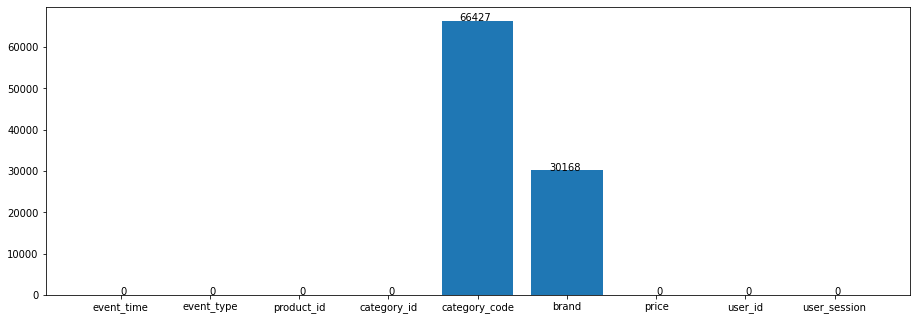

In [141]:
df_nulls = sales.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sales.columns])
df_nulls.show()
barPlot(df_nulls.columns ,[r for r in df_nulls.first()])


In [177]:
# Eliminar nulls

df_sales = sales.select("event_type", "product_id", "category_id", "brand", "user_id", "user_session").where(col("brand").isNotNull() & col("category_code").isNotNull())
df_sales.printSchema()
df_sales.count()


root
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



121427

In [184]:
products = df_sales.select("product_id").distinct()
brands = df_sales.select("brand").distinct()
categories = df_sales.select("category_id").distinct()

products.write.mode("overwrite").parquet("products")
brands.write.mode("overwrite").parquet("brands")
categories.write.mode("overwrite").parquet("categories")



Py4JJavaError: An error occurred while calling o4246.parquet.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:736)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:271)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:287)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:865)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:547)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:587)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:705)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:354)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:178)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:173)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:874)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:548)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:569)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:592)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:689)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:78)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1814)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1791)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:302)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:326)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:343)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:894)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1030)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1039)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:468)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:439)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:516)
	... 21 more


In [196]:
df_session_product = df_sales.select("user_session","product_id").where(col("event_type") == "purchase").dropDuplicates().groupBy('user_session').agg(collect_list('product_id').alias('products'))

df_user_product = df_sales.where(col("event_type") == "purchase").groupBy('user_id').agg(collect_list('product_id').alias('products'))
#df_user_product.show(truncate=False)

df_user_brand = df_sales.where(col("event_type") == "purchase").groupBy('user_id').agg(collect_list('brand').alias('brands'))
#df_user_brand.show(truncate=False)

df_user_category = df_sales.where(col("event_type") == "purchase").groupBy('user_id').agg(collect_list('category_id').alias('categories'))
#df_user_category.show(truncate=False)

df_user_product_v = df_sales.where(col("event_type") == "view").groupBy('user_id').agg(collect_list('product_id').alias('products'))
#df_user_product_v.show(truncate=False)

df_user_brand_v = df_sales.where(col("event_type") == "view").groupBy('user_id').agg(collect_list('brand').alias('brands'))
#df_user_brand_v.show(truncate=False)

df_user_category_v = df_sales.where(col("event_type") == "view").groupBy('user_id').agg(collect_list('category_id').alias('categories'))
#df_user_category_v.show(truncate=False)

df_user_product.write.mode("overwrite").parquet("user_products")
df_user_brand.write.mode("overwrite").parquet("user_brands")
df_user_category.write.mode("overwrite").parquet("user_categories")
df_user_product_v.write.mode("overwrite").parquet("user_products_v")
df_user_brand_v.write.mode("overwrite").parquet("user_brands_v")
df_user_category_v.write.mode("overwrite").parquet("user_categories_v")

Py4JJavaError: An error occurred while calling o5084.parquet.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:736)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:271)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:287)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:865)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:547)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:587)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:705)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:354)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:178)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:173)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:874)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:548)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:569)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:592)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:689)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:78)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1814)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1791)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:302)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:326)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:343)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:894)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1030)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1039)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:468)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:439)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:516)
	... 21 more


In [193]:
df_session_product = df_sales.where(col("event_type") == "purchase").groupBy('user_session').agg(collect_list('product_id').alias('products'))
#df_session_product.show(truncate=False)

df_session_brand = df_sales.where(col("event_type") == "purchase").groupBy('user_session').agg(collect_list('brand').alias('brands'))
#df_session_brand.show(truncate=False)

df_session_category = df_sales.where(col("event_type") == "purchase").groupBy('user_session').agg(collect_list('category_id').alias('categories'))
#df_session_category.show(truncate=False)

df_session_product_v = df_sales.where(col("event_type") == "view").groupBy('user_session').agg(collect_list('product_id').alias('products'))
#df_session_product_v.show(truncate=False)

df_session_brand_v = df_sales.where(col("event_type") == "view").groupBy('user_session').agg(collect_list('brand').alias('brands'))
#df_session_brand_v.show(truncate=False)

df_session_category_v = df_sales.where(col("event_type") == "view").groupBy('user_session').agg(collect_list('category_id').alias('categories'))
#df_session_category_v.show(truncate=False)

df_session_product.write.mode("overwrite").parquet("session_products")
df_session_brand.write.mode("overwrite").parquet("session_brands")
df_session_category.write.mode("overwrite").parquet("session_categories")
df_session_product_v.write.mode("overwrite").parquet("session_products_v")
df_session_brand_v.write.mode("overwrite").parquet("session_brands_v")
df_session_category_v.write.mode("overwrite").parquet("session_categories_v")

+------------------------------------+---------------------------+
|user_session                        |products                   |
+------------------------------------+---------------------------+
|8693715b-2f32-462b-b40b-5535eb559b25|[3700338]                  |
|279f59b0-d73f-445d-84db-29a984780005|[1002544]                  |
|3e5e22a7-ffd8-4023-8b28-fe71da370eab|[1005003]                  |
|d6b4aff1-968c-4789-b1a8-edee55fb1e89|[1004856]                  |
|2af9b570-0942-4dcd-8f25-4d84fba82553|[4804055]                  |
|3a8a2e45-3c9b-4d1a-868f-9fb732f91bab|[1306186]                  |
|62a3b59a-de32-450e-828f-281eac9c02d1|[1004767]                  |
|194fc2ad-6a50-4dc4-aec2-15376159941d|[1004856]                  |
|7842bc7f-6fa3-4b34-a7cc-862401ac7a98|[1004249]                  |
|2c1a11eb-6904-4231-92e7-bdc334f4825f|[1004833, 1004856]         |
|967e0822-8203-4be7-b597-5b7e5fed9cdc|[1801881, 1801690, 1801881]|
|b89b639a-1f8d-4174-8845-fba5787915df|[4803879]               

Py4JJavaError: An error occurred while calling o4773.parquet.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:736)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:271)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:287)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:865)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:547)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:587)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:705)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:354)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:178)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:173)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:874)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:548)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:569)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:592)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:689)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:78)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1814)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1791)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:302)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:326)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:343)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:894)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1030)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1039)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:468)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:439)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:516)
	... 21 more


+--------+-----+
|   brand|count|
+--------+-----+
| samsung|  721|
|   apple|  546|
|  xiaomi|  217|
|  huawei|  105|
|    oppo|   40|
| indesit|   31|
|      lg|   28|
|   artel|   26|
|   midea|   25|
|    acer|   22|
|      hp|   18|
|   bosch|   17|
|  lenovo|   16|
|elenberg|   13|
|    vivo|   12|
+--------+-----+



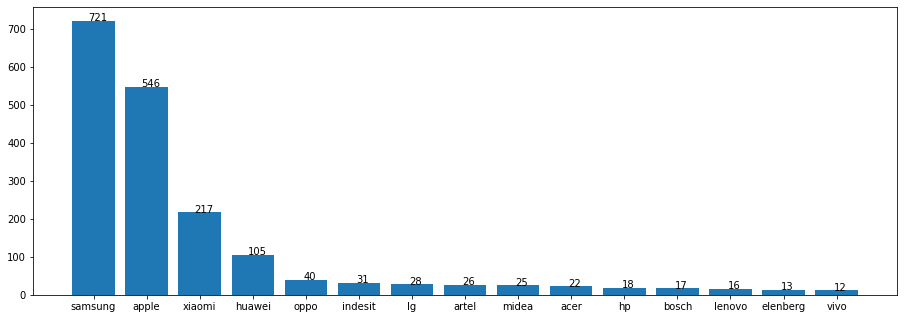

In [178]:
# Count purchase brands

limit = 15
df_count_purchase_brands = df_sales.where(col("event_type") == "purchase").groupBy("brand").count().orderBy(col("count").desc())
df_count_purchase_brands.limit(limit).show()
barPlot([col["brand"] for col in df_count_purchase_brands.select("brand").limit(limit).collect()], [row["count"] for row in df_count_purchase_brands.take(limit)])

+-------+-----+
|  brand|count|
+-------+-----+
|samsung|21223|
|  apple|16966|
| xiaomi|12114|
| huawei| 4654|
|   oppo| 1959|
|     lg| 1890|
|   acer| 1722|
|  bosch| 1504|
|     hp| 1471|
| lenovo| 1456|
|respect| 1221|
|   sony| 1141|
|indesit| 1138|
|  artel| 1118|
|  casio| 1075|
+-------+-----+



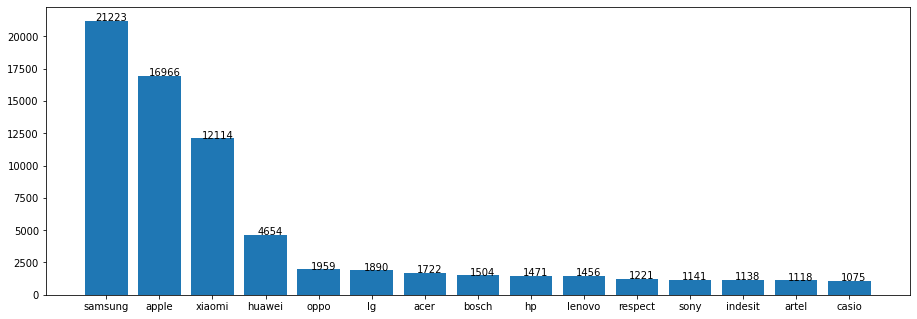

In [179]:
# Count view brands

limit = 15
df_count_view_brands = df_sales.where(col("event_type") == "view").groupBy("brand").count().orderBy(col("count").desc())
df_count_view_brands.limit(limit).show()
barPlot([col["brand"] for col in df_count_view_brands.select("brand").limit(limit).collect()], [row["count"] for row in df_count_view_brands.take(limit)])

In [ ]:
# brands viewed vs brands purchased

limit = 15
df_count_view_brands = df_sales.where(col("event_type") == "view").groupBy("brand").count().orderBy(col("count").desc())
df_count_view_brands.limit(limit).show()
barPlot([col["brand"] for col in df_count_view_brands.select("brand").limit(limit).collect()], [row["count"] for row in df_count_view_brands.take(limit)])


+----------+-------+-----+
|product_id|  brand|count|
+----------+-------+-----+
|   1004856|samsung|  123|
|   1004767|samsung|  101|
|   1002544|  apple|   70|
|   1005115|  apple|   58|
|   1004833|samsung|   51|
|   1004870|samsung|   48|
|   4804056|  apple|   46|
|   1004249|  apple|   39|
|   1004873|samsung|   32|
|   1004741| xiaomi|   31|
|   1005105|  apple|   30|
|   1005100|samsung|   27|
|   1004739| xiaomi|   25|
|   1004750|samsung|   24|
|   4804295| xiaomi|   23|
|   1004836|samsung|   23|
|   1003317|  apple|   20|
|   1004858|samsung|   19|
|   1004838|   oppo|   18|
|   1801881|samsung|   17|
+----------+-------+-----+
only showing top 20 rows



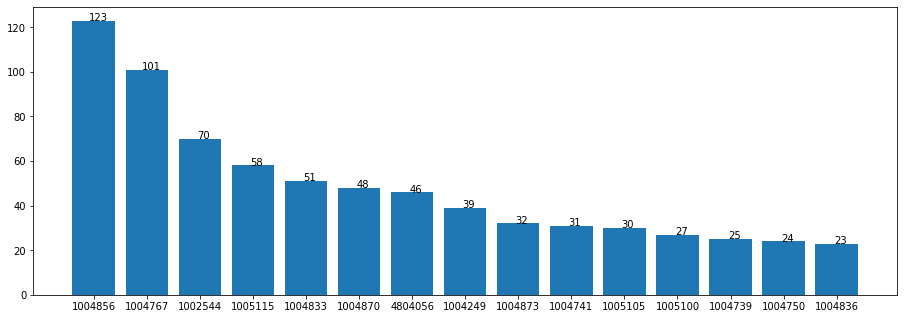

In [180]:
# produto x purchase

limit = 15
products_purchased = df_sales.where(col("event_type") == "purchase").groupBy("product_id", "brand").count().orderBy(col("count").desc())
products_purchased.show()
barPlot([str(col["product_id"]) for col in products_purchased.select("product_id").limit(limit).collect()], [row["count"] for row in products_purchased.take(limit)])

+----------+-------+-----+
|product_id|  brand|count|
+----------+-------+-----+
|   1004856|samsung| 2001|
|   1005115|  apple| 1750|
|   1004767|samsung| 1651|
|   1005105|  apple| 1046|
|   1004870|samsung| 1003|
|   1004833|samsung|  947|
|   1004249|  apple|  924|
|   1002544|  apple|  819|
|   4804056|  apple|  770|
|   1004873|samsung|  696|
|   1004741| xiaomi|  657|
|   1004739| xiaomi|  548|
|   1005160| xiaomi|  532|
|   1004785| huawei|  529|
|   1002524|  apple|  515|
|   1005135|  apple|  513|
|   4804295| xiaomi|  510|
|   1004836|samsung|  506|
|   1005100|samsung|  490|
|   1004565| huawei|  462|
+----------+-------+-----+
only showing top 20 rows



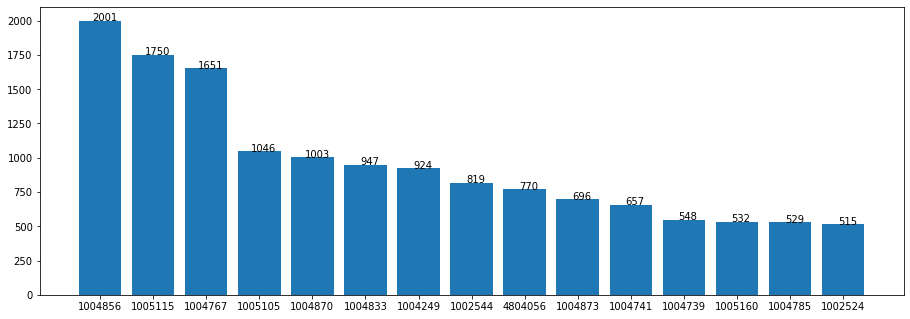

In [181]:
# produto x view

limit = 15
products_purchased = df_sales.where(col("event_type") == "view").groupBy("product_id", "brand").count().orderBy(col("count").desc())
products_purchased.show()
barPlot([str(col["product_id"]) for col in products_purchased.select("product_id").limit(limit).collect()], [row["count"] for row in products_purchased.take(limit)])





category_code x purchase

brands x category_code

category_id





In [198]:
# read csv files

sales = spark.read.csv("dataset/2019-Nov-small.csv", header="true", inferSchema="true", sep=",").union(spark.read.csv("dataset/2019-Oct-small.csv", header="true", inferSchema="true", sep=","))



# Delete nulls (brand and category_code)

df_sales = sales.select("event_type", "product_id", "category_id", "brand", "user_id", "user_session").where(col("brand").isNotNull() & col("category_code").isNotNull())



# Create parquet for product, brand and category

df_sales.select("product_id").distinct().write.mode("overwrite").parquet("products")
df_sales.select("brand").distinct().write.mode("overwrite").parquet("brands")
df_sales.select("category_id").distinct().write.mode("overwrite").parquet("categories")



# Create user parquet for purchase and view (_v) events

df_sales.select("user_id","product_id").where(col("event_type") == "purchase").dropDuplicates().groupBy('user_id').agg(collect_list('product_id').alias('products')).write.mode("overwrite").parquet("user_products")
df_sales.select("user_id","brand").where(col("event_type") == "purchase").dropDuplicates().groupBy('user_id').agg(collect_list('brand').alias('brands')).write.mode("overwrite").parquet("user_brands")
df_sales.select("user_id","category_id").where(col("event_type") == "purchase").dropDuplicates().groupBy('user_id').agg(collect_list('category_id').alias('categories')).write.mode("overwrite").parquet("user_categories")
df_sales.select("user_id","product_id").where(col("event_type") == "view").dropDuplicates().groupBy('user_id').agg(collect_list('product_id').alias('products')).write.mode("overwrite").parquet("user_products_v")
df_sales.select("user_id","brand").where(col("event_type") == "view").dropDuplicates().groupBy('user_id').agg(collect_list('brand').alias('brands')).write.mode("overwrite").parquet("user_brands_v")
df_sales.select("user_id","category_id").where(col("event_type") == "view").dropDuplicates().groupBy('user_id').agg(collect_list('category_id').alias('categories')).write.mode("overwrite").parquet("user_categories_v")



# Create session parquet for purchase and view (_v) events

df_sales.select("user_session","product_id").where(col("event_type") == "purchase").dropDuplicates().groupBy('user_session').agg(collect_list('product_id').alias('products')).write.mode("overwrite").parquet("session_products")
df_sales.select("user_session","brand").where(col("event_type") == "purchase").dropDuplicates().groupBy('user_session').agg(collect_list('brand').alias('brands')).write.mode("overwrite").parquet("session_brands")
df_sales.select("user_session","category_id").where(col("event_type") == "purchase").dropDuplicates().groupBy('user_session').agg(collect_list('category_id').alias('categories')).write.mode("overwrite").parquet("usession_categories")
df_sales.select("user_session","product_id").where(col("event_type") == "view").dropDuplicates().groupBy('user_session').agg(collect_list('product_id').alias('products')).write.mode("overwrite").parquet("session_products_v")
df_sales.select("user_session","brand").where(col("event_type") == "view").dropDuplicates().groupBy('user_session').agg(collect_list('brand').alias('brands')).write.mode("overwrite").parquet("session_brands_v")
df_sales.select("user_session","category_id").where(col("event_type") == "view").dropDuplicates().groupBy('user_session').agg(collect_list('category_id').alias('categories')).write.mode("overwrite").parquet("session_categories_v")


Py4JJavaError: An error occurred while calling o5164.parquet.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:736)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:271)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:287)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:865)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:547)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:587)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:705)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:354)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:178)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:173)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:874)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:548)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:569)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:592)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:689)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:78)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1814)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1791)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:302)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:326)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:343)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:894)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1030)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1039)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:468)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:439)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:516)
	... 21 more
